## Forecasting System - Project Demand of Products at a Retail Outlet Based on Historical Data

####  Forecasting sales using ARIMA, SARIMA ,xgboost

In [2]:

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools



%matplotlib inline
import matplotlib
plt.style.use('ggplot')
import warnings
import itertools
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

In [3]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
train=pd.read_csv(r"C:\Users\jithi\Desktop\Vinu DSA\internship\train.csv\train.csv")
train.head()


date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [5]:
test=pd.read_csv(r"C:\Users\jithi\Desktop\Vinu DSA\internship\test.csv")
test.head()


id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1

In [6]:
train["date"].min()


'2013-01-01'

In [7]:
train["date"].max()


'2017-12-31'

In [8]:
train["store"].nunique()


10

In [9]:
train["item"].nunique() 


50

In [10]:
train.groupby(["store"])["item"].nunique()


store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [11]:
def monthlyORyears_sales(data,time=['monthly','years']):
    data = data.copy()
    if time == "monthly":
        # Drop the day indicator from the date column:
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
   # Sum sales per month: 
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)
        
    return data

In [12]:
def sales_time(data):
    """Time interval of dataset:"""

    train.date = pd.to_datetime(train.date)
    n_of_days = train.date.max() - train.date.min()
    n_of_years = int(n_of_days.days / 365)
    
    print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonth: {12 * n_of_years}")

In [13]:
sales_time(train)

Days: 1825
Years: 5
Month: 60


In [14]:
import datetime
lag_size = len(test['date'].unique())
print('Forecast lag size: ', lag_size)

Forecast lag size:  90


In [15]:
def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, color='yellow')
    
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    
    return sales_by_store

store    sales
0      1  4315603
1      2  6120128
2      3  5435144
3      4  5012639
4      5  3631016
5      6  3627670
6      7  3320009
7      8  5856169
8      9  5025976
9     10  5360158

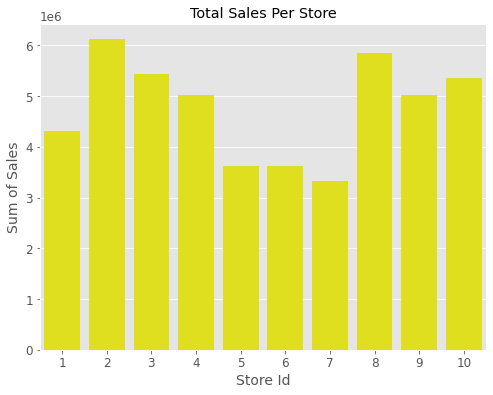

In [16]:
sales_per_store(train)

In [17]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')

y_2013 = train.loc[(train['date'] >= '2012-12-31')
                     & (train['date'] <= '2013-12-31')]

In [18]:
monthwise= y_2013.groupby(y_2013['date'].dt.strftime('%B'))[['store','item','sales']]


In [19]:
y_2013[:365]


date  store  item  sales
0   2013-01-01      1     1     13
1   2013-01-02      1     1     11
2   2013-01-03      1     1     14
3   2013-01-04      1     1     13
4   2013-01-05      1     1     10
..         ...    ...   ...    ...
360 2013-12-27      1     1     18
361 2013-12-28      1     1     17
362 2013-12-29      1     1     14
363 2013-12-30      1     1      5
364 2013-12-31      1     1     15

[365 rows x 4 columns]

In [24]:
fig = px.line(y_2013[:365], x="date", y="sales", title='Sales record for Store 1 Item 1 in Year 2013')
fig.show()

In [20]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [21]:
import plotly.express as px


In [22]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
print(daily_sales)

           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]


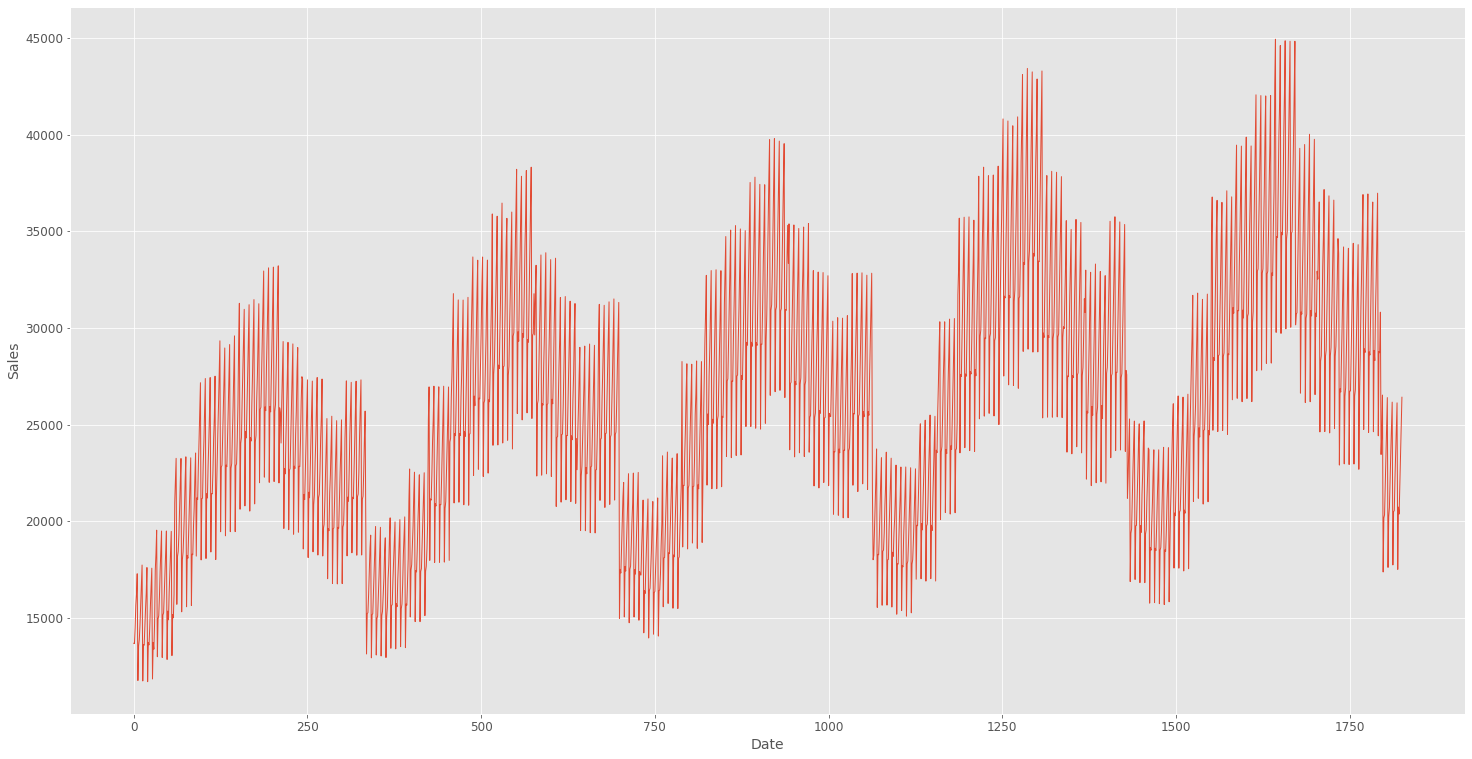

In [23]:
plt.figure(figsize=(25,13))
plt.plot(daily_sales.sales, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [27]:
monthwise= y_2013.groupby(y_2013[:365]['date'].dt.strftime('%B'))[['sales']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

sales
date                
January    10.580645
February   11.500000
March      15.387097
April      17.400000
May        17.129032
June       20.900000
July       21.322581
August     19.161290
September  17.300000
October    15.612903
November   19.066667
December   12.516129

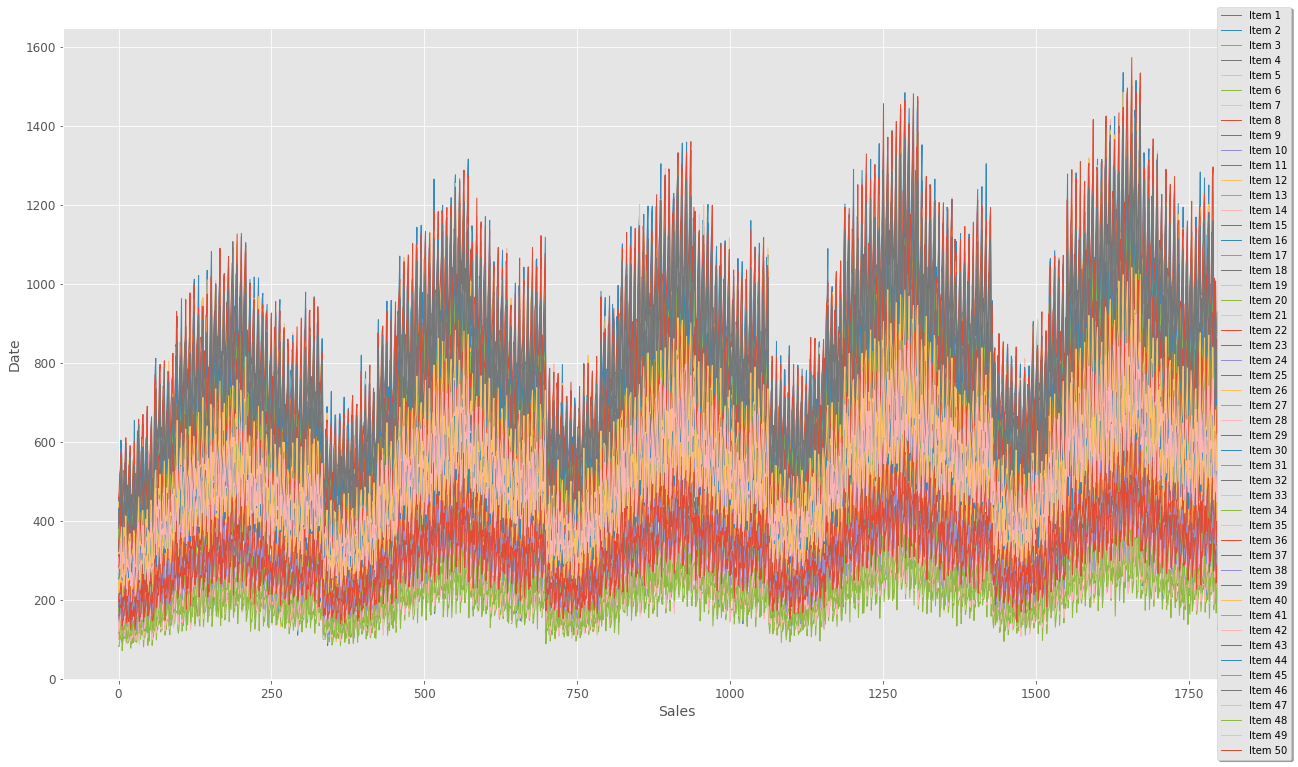

In [28]:
plt.figure(figsize=(22,12))
legend = []
for i in range(50):
    item_sales=train.loc[train['item'] == i]
    item_sales=item_sales.groupby('date', as_index=False)['sales'].sum()
    item_sales=item_sales.reset_index()['sales']
    plt.plot(item_sales, linewidth=1)    
    legend.append(('Item '+str(i+1)))
plt.xlabel('Sales')
plt.ylabel('Date')
plt.legend(legend, loc='upper right', ncol=1, bbox_to_anchor=[1.005, 1.04], fancybox=True, shadow=True)
plt.show()

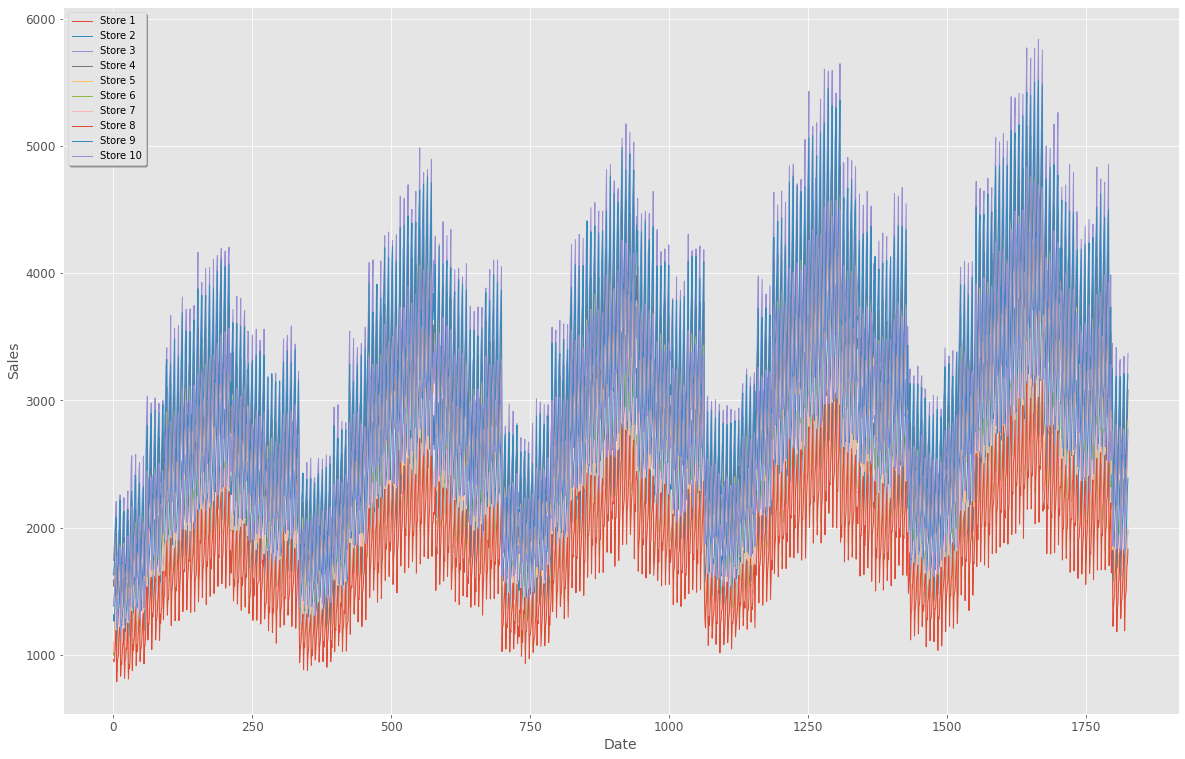

In [29]:
plt.figure(figsize=(20,13))
legend = []
for i in range(10):
    store_sales=train.loc[train['store'] == i]
    store_sales=store_sales.groupby('date', as_index=False)['sales'].sum()
    store_sales=store_sales.reset_index()['sales']
    plt.plot(store_sales, linewidth=1)    
    legend.append(('Store '+str(i+1)))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(legend, loc='upper left', ncol=1, fancybox=True, shadow=True)
plt.show()

In [30]:
train.groupby(["store"])["item"].nunique()


store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [36]:
train_d = train.copy()

In [37]:
train_d['month'] = pd.to_datetime(train_d['date']).dt.month
train_d['year'] = pd.to_datetime(train_d['date']).dt.year
train_d['day_of_week'] = pd.to_datetime(train_d['date']).dt.dayofweek
train_d['week_of_year'] = pd.to_datetime(train_d['date']).dt.weekofyear
train_d['day_of_year'] = pd.to_datetime(train_d['date']).dt.day_of_year
train_d['day_of_month'] = pd.to_datetime(train_d['date']).dt.day



train_d

date  store  item  sales  month  year  day_of_week  week_of_year  \
0      2013-01-01      1     1     13      1  2013            1             1   
1      2013-01-02      1     1     11      1  2013            2             1   
2      2013-01-03      1     1     14      1  2013            3             1   
3      2013-01-04      1     1     13      1  2013            4             1   
4      2013-01-05      1     1     10      1  2013            5             1   
...           ...    ...   ...    ...    ...   ...          ...           ...   
912995 2017-12-27     10    50     63     12  2017            2            52   
912996 2017-12-28     10    50     59     12  2017            3            52   
912997 2017-12-29     10    50     74     12  2017            4            52   
912998 2017-12-30     10    50     62     12  2017            5            52   
912999 2017-12-31     10    50     82     12  2017            6            52   

        day_of_year  day_of_month  
0                 1             1  
1                 2             2  
2                 3             3  
3                 4             4  
4                 5             5  
...             ...           ...  
912995          361            27  
912996          362            28  
912997          363            29  
912998          364            30  
912999          365            31  

[913000 rows x 10 columns]

In [38]:
train_d.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [39]:
datetime_series = pd.Series(
    pd.date_range("2013-01-01", periods=12, freq="M")
)
datetime_series

0    2013-01-31
1    2013-02-28
2    2013-03-31
3    2013-04-30
4    2013-05-31
5    2013-06-30
6    2013-07-31
7    2013-08-31
8    2013-09-30
9    2013-10-31
10   2013-11-30
11   2013-12-31
dtype: datetime64[ns]

In [40]:
month = datetime_series.dt.month 

In [41]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [42]:
train_d.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
train_d.head(10)

date  store  item  sales  month  year  day_of_week  week_of_year  \
0 2013-01-01      1     1     13      1  2013            1             1   
1 2013-01-02      1     1     11      1  2013            2             1   
2 2013-01-03      1     1     14      1  2013            3             1   
3 2013-01-04      1     1     13      1  2013            4             1   
4 2013-01-05      1     1     10      1  2013            5             1   
5 2013-01-06      1     1     12      1  2013            6             1   
6 2013-01-07      1     1     10      1  2013            0             2   
7 2013-01-08      1     1      9      1  2013            1             2   
8 2013-01-09      1     1     12      1  2013            2             2   
9 2013-01-10      1     1      9      1  2013            3             2   

   day_of_year  day_of_month  
0            1             1  
1            2             2  
2            3             3  
3            4             4  
4            5             5  
5            6             6  
6            7             7  
7            8             8  
8            9             9  
9           10            10

#### Item 1 and store 1 is taken

In [43]:
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d") #If need extract year, month and day to new columns:

# per 1 store, 1 item
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]


train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df.head() 

date  store  item  sales  year  month  day  weekday
0 2013-01-01      1     1     13  2013      1    1        1
1 2013-01-02      1     1     11  2013      1    2        2
2 2013-01-03      1     1     14  2013      1    3        3
3 2013-01-04      1     1     13  2013      1    4        4
4 2013-01-05      1     1     10  2013      1    5        5

<AxesSubplot:xlabel='date', ylabel='sales'>

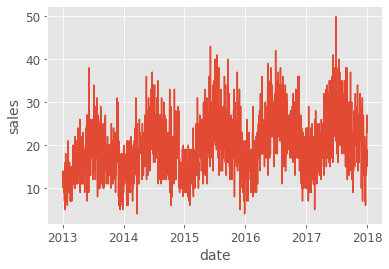

In [44]:

sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)


<AxesSubplot:xlabel='date', ylabel='sales'>

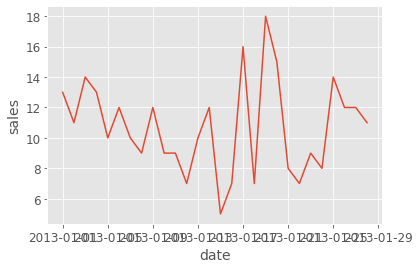

In [45]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])


<AxesSubplot:xlabel='weekday', ylabel='sales'>

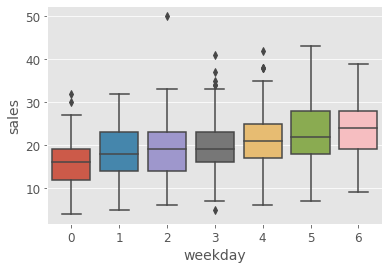

In [46]:
sns.boxplot(x="weekday", y="sales", data=train_df)



In [48]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
train_df

store  item  sales  year  month  day  weekday
date                                                     
2013-01-01      1     1   13.0  2013      1    1        1
2013-01-02      1     1   11.0  2013      1    2        2
2013-01-03      1     1   14.0  2013      1    3        3
2013-01-04      1     1   13.0  2013      1    4        4
2013-01-05      1     1   10.0  2013      1    5        5
...           ...   ...    ...   ...    ...  ...      ...
2017-12-27      1     1   14.0  2017     12  361        2
2017-12-28      1     1   19.0  2017     12  362        3
2017-12-29      1     1   15.0  2017     12  363        4
2017-12-30      1     1   27.0  2017     12  364        5
2017-12-31      1     1   23.0  2017     12  365        6

[1826 rows x 7 columns]

<Figure size 432x288 with 0 Axes>

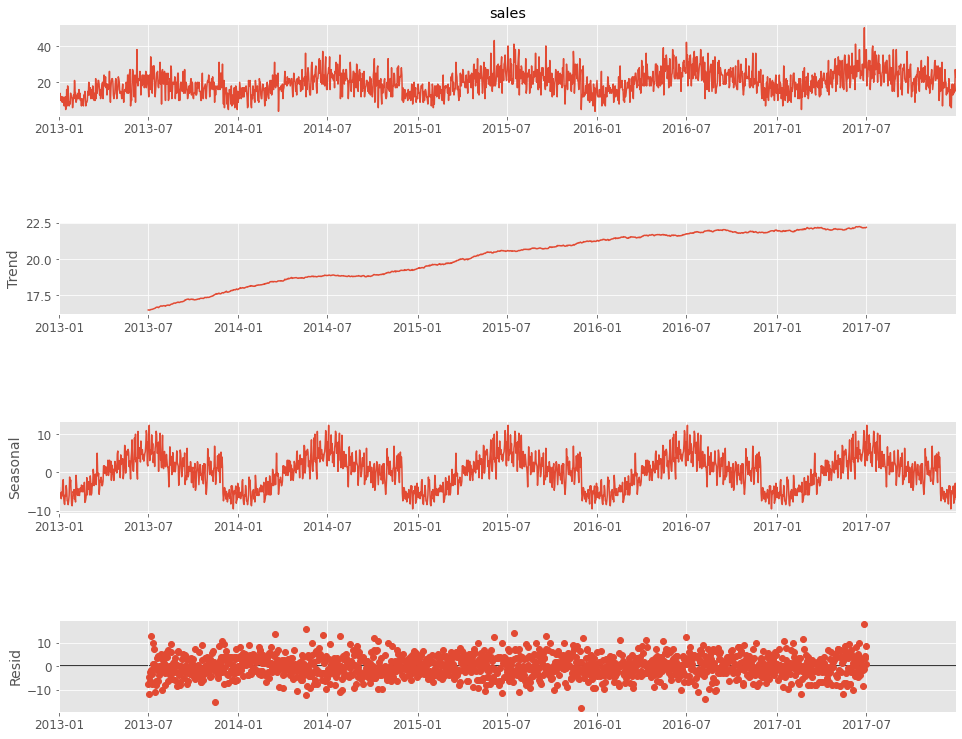

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', period=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)



In [60]:
train

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [61]:
train_d

store  item  sales  month  year  day_of_week  week_of_year  \
date                                                                     
2013-01-01      1     1   13.0      1  2013            1             1   
2013-01-02      1     1   11.0      1  2013            2             1   
2013-01-03      1     1   14.0      1  2013            3             1   
2013-01-04      1     1   13.0      1  2013            4             1   
2013-01-05      1     1   10.0      1  2013            5             1   
...           ...   ...    ...    ...   ...          ...           ...   
2017-12-27     10    50   63.0     12  2017            2            52   
2017-12-28     10    50   59.0     12  2017            3            52   
2017-12-29     10    50   74.0     12  2017            4            52   
2017-12-30     10    50   62.0     12  2017            5            52   
2017-12-31     10    50   82.0     12  2017            6            52   

            day_of_year  day_of_month  
date                                   
2013-01-01            1             1  
2013-01-02            2             2  
2013-01-03            3             3  
2013-01-04            4             4  
2013-01-05            5             5  
...                 ...           ...  
2017-12-27          361            27  
2017-12-28          362            28  
2017-12-29          363            29  
2017-12-30          364            30  
2017-12-31          365            31  

[913000 rows x 9 columns]

###### Average number of sale each month

In [66]:
y = train_df['sales'].resample('MS').mean()
y.head()

date
2013-01-01    10.580645
2013-02-01    11.500000
2013-03-01    15.387097
2013-04-01    17.400000
2013-05-01    17.129032
Freq: MS, Name: sales, dtype: float64

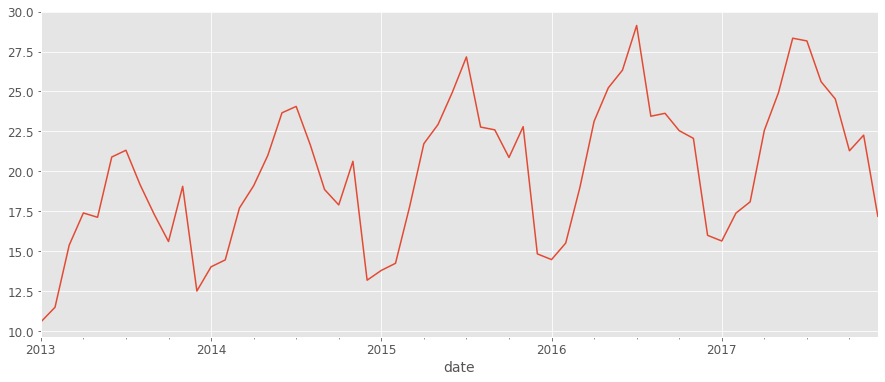

In [67]:
y.plot(figsize=(15, 6))
plt.show()

In [68]:
#from pylab import rcParams
#import statsmodels.api as sm
#rcParams['figure.figsize'] = 16, 10
#decomposition = sm.tsa.seasonal_decompose(y, model='additive')
#fig = decomposition.plot()
#plt.show()

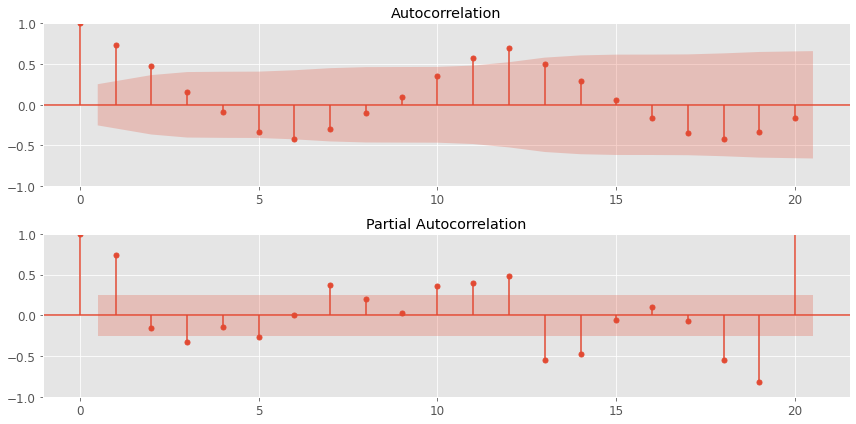

In [69]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y,lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y,lags=20,ax=ax2)
plt.tight_layout()

In [ ]:
## checking if it is stationary

In [70]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    
  #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    fig= plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='orange',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    
      #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

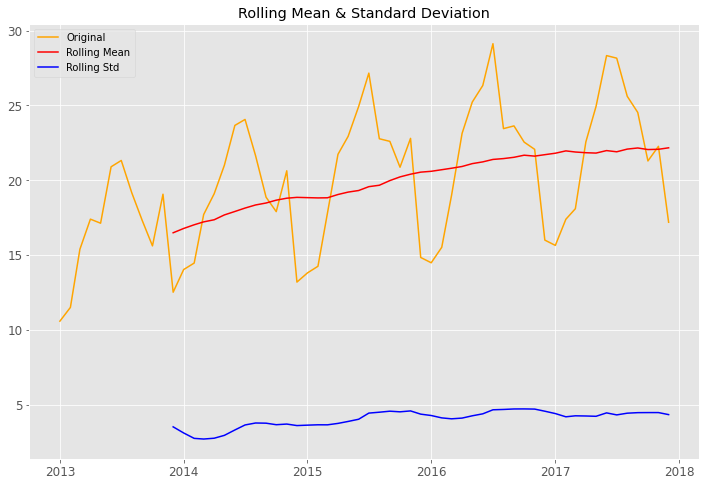

Results of Dickey-Fuller Test:
p-value = 0.0012. The series is likely stationary.
Test Statistic                 -4.051322
p-value                         0.001164
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [71]:
test_stationarity(y)

In [ ]:
##P value is less than 0.05 and so it is stationary

In [ ]:
#### Grid search  to find the optimal set of parameters that yields the best performance for our model.

In [74]:
def PDQ(y):   
    p = d = q = range(0, 3)
    
    pdq = list(itertools.product(p, d, q))

    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(param, param_seasonal, output.aic))
            except:
                continue
    

In [75]:
PDQ(y)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =526.2351928268366
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =387.57192038269926
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =281.79443544557665
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =192.87416216023786
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =882.6812539307653
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =77.423955062296
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =134.96284298981666
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =90.08703428215146
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =49.8042864493327
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =168.776589412485
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =163.9688851470509
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =116.25744832693702
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =125.85326363140604
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1391.0690615494257
ARIMA (0, 0, 0) x

### Lowest AIC value here is 33.80 for (0,1,2)x(1,2,2,12)

In [ ]:
#####Fitting the ARIMA model



In [76]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8121      0.208     -3.912      0.000      -1.219      -0.405
ma.L2          0.1118      0.176      0.635      0.525      -0.233       0.457
ar.S.L12      -0.7647     23.455     -0.033      0.974     -46.736      45.207
ma.S.L12   -3.746e-06    3.3e+04  -1.14e-10      1.000   -6.46e+04    6.46e+04
ma.S.L24      -1.0003   3319.724     -0.000      1.000   -6507.539    6505.539
sigma2         1.2697   4230.643      0.000      1.000   -8290.639    8293.178


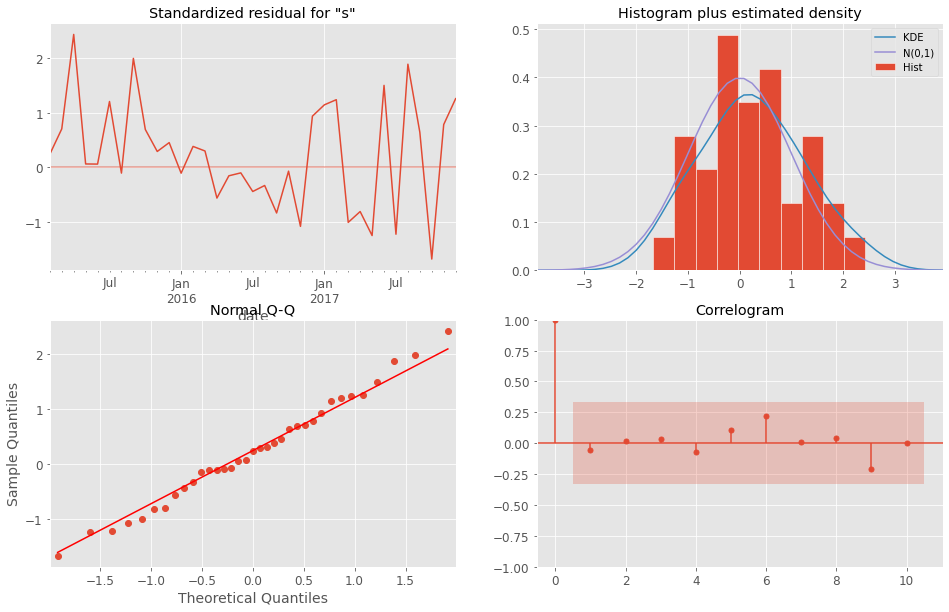

In [77]:
results.plot_diagnostics()
plt.show()

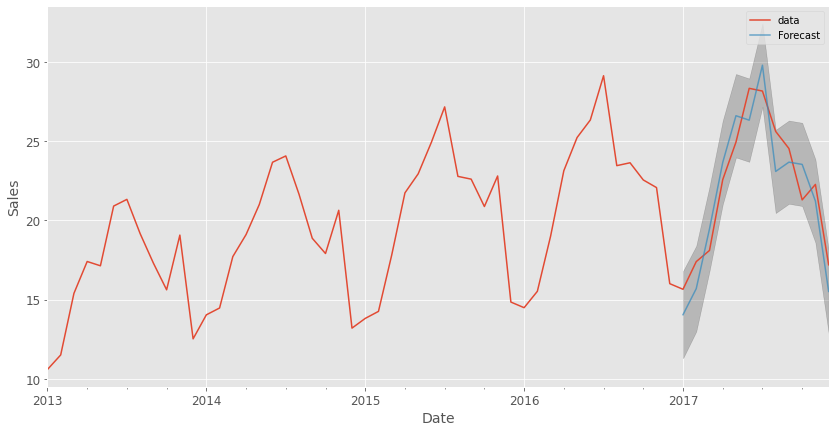

In [94]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='data')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [81]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2.84


In [ ]:
###sales forecast for next 3 years

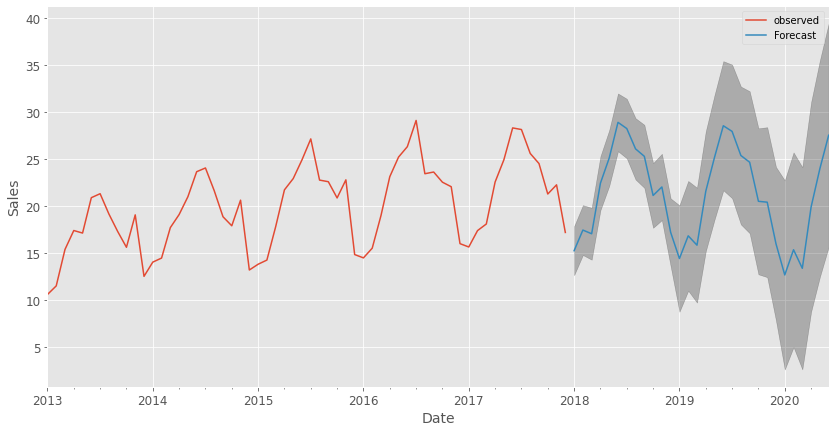

In [116]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [117]:
my_submission =pd.read_csv(r"C:\Users\jithi\Desktop\Vinu DSA\internship\sample_submission.csv")
my_submission

id  sales
0          0     52
1          1     52
2          2     52
3          3     52
4          4     52
...      ...    ...
44995  44995     52
44996  44996     52
44997  44997     52
44998  44998     52
44999  44999     52

[45000 rows x 2 columns]

## xgboost model

In [63]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [118]:
import xgboost as xgb


In [119]:
dtrain = xgb.DMatrix(data=train[['store', 'item']],
                     label=train['sales'])

# Define xgboost parameters
params = {'objective': 'reg:linear',
          'max_depth': 3 ,
          'silent': 1}

# Train xgboost model
xg_depth_20 = xgb.train(params=params, dtrain=dtrain)

[21:02:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:02:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [120]:
from sklearn.metrics import mean_squared_error

dtest = xgb.DMatrix(data=test[['store', 'item']])


    # Make predictions
train_pred = xg_depth_20.predict(dtrain)     
test['sales'] =  xg_depth_20.predict(dtest)          
    
    # Calculate metrics
mse_train = mean_squared_error(train['sales'], train_pred)                  
mse_test = mean_squared_error(train.sales[0:45000], test['sales'])
print('MSE Train: {:.3f}. MSE Test: {:.3f}'.format(mse_train, mse_test))

MSE Train: 500.043. MSE Test: 815.021


In [121]:
print(test['sales'])

0        23.515894
1        23.515894
2        23.515894
3        23.515894
4        23.515894
           ...    
44995    60.111858
44996    60.111858
44997    60.111858
44998    60.111858
44999    60.111858
Name: sales, Length: 45000, dtype: float32


In [122]:
#test[['id','sales']].to_csv('sample_submission.csv', index = False)

In [123]:
my_submission = pd.DataFrame({'id':test.id,'sales':test.sales})

In [124]:
my_submission.to_csv('sample_submission.csv',index = False)

In [125]:
my_submission

id      sales
0          0  23.515894
1          1  23.515894
2          2  23.515894
3          3  23.515894
4          4  23.515894
...      ...        ...
44995  44995  60.111858
44996  44996  60.111858
44997  44997  60.111858
44998  44998  60.111858
44999  44999  60.111858

[45000 rows x 2 columns]